In [6]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
from ase.io import read

(examples:saed_quickstart)=
# SAED quickstart

This notebook demonstrates a basic simulation of selected area electron diffraction of SiO<sub>2</sub> zeolite.

## Configuration

We start by (optionally) setting our configuration. See [documentation](reference:configuration) for details.

In [7]:
abtem.config.set({"device": "cpu", "fft": "fftw"})

## Atomic model
We import a unit cell from a .cif-file. See our [walkthough](walkthrough:atomic_models) or our [tutorial](tutorials:advanced_atomic_models) on atomic models. 

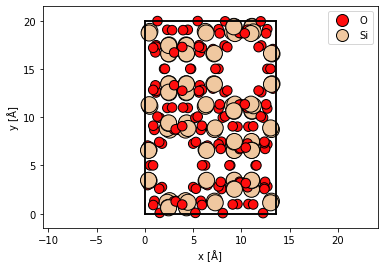

In [8]:
sio2 = read("data/SiO2.cif")

abtem.show_atoms(sio2, plane="xy", legend=True);

The structure is rotated such that the previous $xy$-plane is rotated into the $xz$-plane. The structure is repeated along $z$ to obtain the required thickness. If frozen phonons are required the structure should also be repeated in the $xy$ to describe a thermal ensemble.

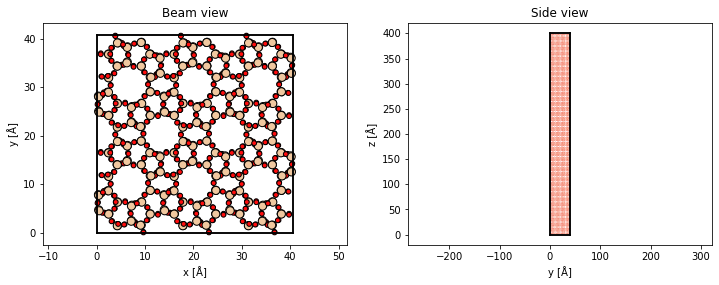

In [9]:
sio2_rotated = abtem.atoms.rotate_atoms_to_plane(sio2, "xz")

sio2_repeated = sio2_rotated * (3, 2, 20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(sio2_repeated, ax=ax1, plane="xy", title="Beam view")
abtem.show_atoms(sio2_repeated, ax=ax2, plane="yz", title="Side view", linewidth=0);

## Potential

We create an ensemble of potentials using the frozen phonon model. See our [walkthrough on frozen phonons](walkthrough:frozen_phonons). 

In [41]:
frozen_phonons = abtem.FrozenPhonons(sio2_repeated, 8, sigmas=0.1)

We create a potential from the frozen phonons model, see [walkthrough on potentials](walkthrough:potentials).

In [12]:
potential = abtem.Potential(
    frozen_phonons,
    gpts=512,
    projection="infinite",
    slice_thickness=2,
    exit_planes=50,
)

## Wave function

We create a plane wave function at an energy of $200 \ \mathrm{keV}$. See our [walkthrough on wave functions](walkthrough:wave_functions). 

In [13]:
wave = abtem.PlaneWave(energy=200e3)

## Multislice

We run the multislice algorithm to calculate the exit waves, see our [walkthrough on multislice](walkthrough:multislice).

In [14]:
exit_waves = wave.multislice(potential)

We calculate the diffraction patterns up to a scattering angle of $10 \ \mathrm{mrad}$.

In [15]:
measurement_ensemble = exit_waves.diffraction_patterns(max_angle=10)

measurement_ensemble.shape

(8, 5, 35, 35)

The result is an ensemble of images, one for each frozen phonon and exit plane, we average the ensemble across the phonon dimensions obtain the final thickness series. 

In [16]:
measurement = measurement_ensemble.mean(0)

measurement.compute()

[########################################] | 100% Completed | 13.22 s


## Visualize results

We show the thickness series as an exploded plot. Before plotting the direct beam is blocked as it typically has a much higher intensity than the scattered beams.

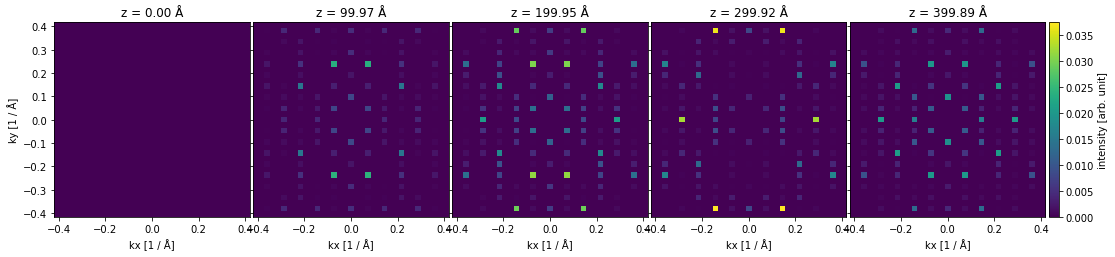

In [17]:
fig, ax = measurement.block_direct().show(
    explode=True,
    figsize=(18, 5),
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
    common_color_scale=True,
)

## Index diffraction patterns

Instead of the pixelated representation above, the diffraction patterns can be represented as a collection indexed diffraction intensities.

In [34]:
# the conventional unit cell is given here 
indexed_spots = measurement.index_diffraction_spots(cell=sio2.cell)

# remove low intensity spots
indexed_spots = indexed_spots.remove_low_intensity(0.1)

We show the last diffraction spots in the thickness series with an overlay showing the miller indices.

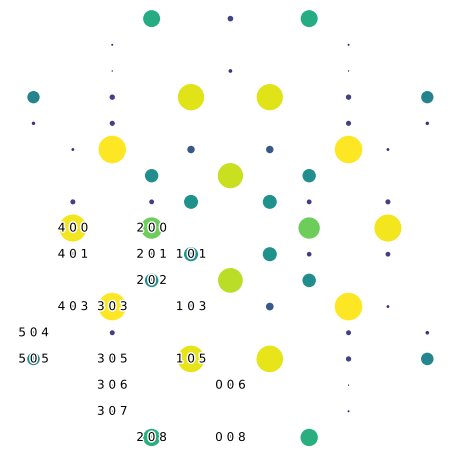

In [36]:
indexed_spots[-1].show(spot_scale=.7, figsize=(8,8));

The diffraction spots can be converted to a [pandas](https://pandas.pydata.org/) dataframe.

In [37]:
df = indexed_spots.remove_low_intensity(.4).to_dataframe(normalize=True)

df

,1 0 1,1 0 5,2 0 0,2 0 8,3 0 3,4 0 0,5 0 5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.208935,0.644949,0.105712,0.113023,0.391170,0.102825,0.059345
2,0.359232,0.836100,0.223646,0.780212,0.467400,0.556465,0.368685
3,0.107570,0.026248,0.208181,1.000000,0.062737,0.864694,0.458806
4,0.283882,0.535871,0.430794,0.349848,0.556043,0.545422,0.252523


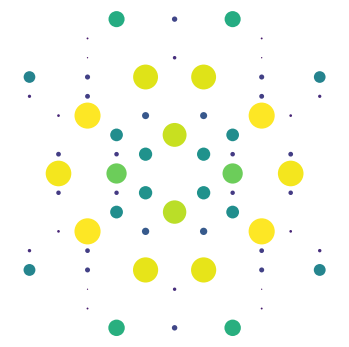

In [40]:
fig, ax = indexed_spots[-1].show(spot_scale=0.9, overlay_indices=False)

ax.axis("off")
plt.savefig("../thumbnails/saed_quickstart.png", bbox_inches="tight", pad_inches=0)